<a id="libraries"></a>
<b><h1>1. Libraries</h1>

In [1]:
# Data Manipulating and Visualization
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random

# Operating System
import os
from datetime import datetime
import warnings
import pickle
from argparse import Namespace
import joblib
from datetime import datetime

# Machine Learning Algorithms
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# Performance metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

# Hyperparameter
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

## Mathematics and Statistics
import scipy.stats as stats
from scipy.stats import uniform
from scipy.stats import loguniform

# NLP related 
import string
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

<a id="arguments"></a>
<b><h1>2. Global Arguments</h1>

In [13]:
args = Namespace(
    ##### File names and path names
    input_file_name     = '/kaggle/input/imdb-data/IMDb_dataset.csv',
    output_path         = '/kaggle/working/',
    rs_results_filename = '/kaggle/input/imdb-outputs/rs_results.csv',
    model_data_name     = '/kaggle/input/imdb-data/Modeling_Data_50_features.csv',
    
    ##### Features
    target_feature     = 'sentiment_number',
    
    ##### For generating TFIDF features
    feature_tfidf      = 'movie_review',
    feature_tfidf_abbr = 'rv',
    ## To save time, keep the number of TFIDF features to be low 
    max_features       = 50,
    min_df             = 0.01,
    
    ##### Data Treatment
    missing_th         = 0.5,
    
    ##### Training
    test_size          = 0.3,
    partition_seed     = 42,
    tuning_metric      = 'roc_auc',
    tuning_metric_higher_better = True,
    params_LGB         = {'boosting_type'    : 'gbdt',
                          'objective'        : 'binary',
                          'colsample_bytree' : 0.2,
                          'learning_rate'    : 0.05,
                          'min_child_samples': 10,
                          'min_child_weight' : 5,
                          'max_depth'        : -1,
                          'min_split_gain'   : 0,
                          'num_leaves'       : 31,
                          'subsample_for_bin': 50000,
                          'subsample_freq'   : 1,
                          'n_estimators'     : 5000}
    )

<a id="helper_functions"></a>
<b><h1>3. Helper Functions</h1>

In [3]:
def print_description(text,n=100):
    """
    This function prints a description.
    Attribute: 
            text (str) - a text to print
    """
    print(text)
    print('-'*n)
    

<a id="classes"></a>
<b><h1>4. Classes</h1>

<a id="class_data_analysis"></a>
<h2>Class Data_Analysis()</h2>

In [4]:
class Data_Analysis():
    """
    This class is used to conduct data analysis for a given dataset.
    """
    
    def __init__(self):
        self.data_of_interest       = None
        self.descriptive_statistics = None
        print_description("Data_Analysis object is created")
    
    @staticmethod
    def get_missing_values(data):
        """
        This function gets missing value information.
        Attribute: 
            data (DataFrame) - the data of interest
        Return: 
            (DataFrame) - inforamtion about missing value for all columns
        """
        missing_info = data.apply(lambda x:x.isna().sum()).reset_index()
        missing_info.columns = ['feature','n_miss']
        missing_info['n_non_missing'] = data.apply(lambda x:x.count()).values
        missing_info['n'] = missing_info['n_non_missing'] + missing_info['n_miss']
        missing_info['p_miss'] = missing_info['n_miss'] / missing_info['n']
        return missing_info
    
    def get_descriptive_statistics(self, data):
        """
        This function gets missing value information.
        Attribute: 
            data (DataFrame) - the data of interest
        Return: 
            self.descriptive_statistics - updated 
        """
        self.data_of_interest = data
        ds_df = self.get_missing_values(data)
        ds_df['Type']     = data.dtypes.values
        ds_df['N_unique'] = data.nunique().values
        ds_df['Mean']     = data.apply(lambda x: x.mean() if x.dtype!='O' else pd.NA).values
        
        sample = data.sample(n=5,replace=True)
        for i in range(data.shape[1]):
            feature = data.columns[i]
            ds_df.loc[i,'sample'] = ','.join(sample[feature].astype(str))
        
        self.descriptive_statistics = ds_df
        print_description("Descriptive statistics are created")

<a id="class_x_data_treatment"></a>
<h2>Class X_Data_Treatment()</h2>

In [5]:
class X_Data_Treatment():
    """
    This class is used to conduct data manipulation in the X_Data.
        - missing data imputation
        - create TFIDF features based on a given text feature in X_Data
    """
    
    def __init__(self, data_original):
        self.data_original  = data_original
        self.run_imputation = False 
        self.data_imputed   = data_original
        self.run_tfidf      = False
        self.data_tfidf     = None
        print_description("Data_Treatment object is created")
        
    def remove_na_rows(self, feature):
        """
        This function removes the rows with missing value(nan) in feature columns.
        This function should be used before running function fill_na()
        Attribute: 
            feature (str) - the name of the column (one column)
        Return: 
            self.data_original - updated
        """
        df = self.data_original.copy()
        n1 = len(df)
        df = df.loc[df[feature].notna(),:]
        n2 = len(df)
        n_removed = n1-n2 
        self.data_original = df
        print_description("{} rows with nan in '{}' are removed"\
                          .format(n_removed,feature))
    
    def fill_na(self, strategy):
        """
        This function conducts missing value imputation.
        Attribute: 
            strategy (str) - a given strategy: 'mode','mean','median','none'
        Return: 
            self.imputation - updated
            self.data_imputed - updated
        """
        data_to_fillna = self.data_original
        
        if strategy == 'mode':
            data_filled = data_to_fillna.apply(lambda x:x.fillna(x.mode()[0]))
        elif strategy == 'mean':
            data_filled = data_to_fillna.apply(lambda x:x.fillna(x.mean()))
        elif strategy == 'median':
            data_filled = data_to_fillna.apply(lambda x:x.fillna(x.median()))
        elif strategy == 'none':
            data_filled = data_to_fillna
            if data_to_fillna.isna().sum().any():
                print_description("Warning - missing value detected, but not imputed")
        else:
            print_description("Error - imputation strategy is not correctly specified")

        self.imputation      = True
        self.data_imputed    = data_filled
    
    def create_tfidf_features(self, feature, feature_abbr, args):
        """
        This function creates TFIDF features with a given feature. 
        Attribute:
            feature (str) - the name for feature used for TFIDF process
            feature_abbr (str) - an abbreviation for feature that will be 
                                  used in TFIDF feature names
            args - global arguments    
        Return: 
            self.data_tfidf - updated
        """
        def lower_string(string):
            return string.lower()
        
        def remove_special_strips(text,term):
            return text.replace(term, "")
        
        def text_treatment(text):
            text = lower_string(text)
            text = remove_special_strips(text,'<br />')
            stop_punc = set(stopwords.words('english') + list(string.punctuation))
            tokenizer = ToktokTokenizer()
            filtered_tokens = [i for i in tokenizer.tokenize(text) if i not in stop_punc]
            filtered_tokens = [i.replace('.', "") for i in filtered_tokens]
            filtered_text   = ' '.join(filtered_tokens) 
            return(filtered_text)
        
        def stemmer(text):
            sinlge_stemmer = PorterStemmer()
            words = text.split()
            words_stem = [sinlge_stemmer.stem(i) for i in words]
            text_stem  = ' '.join(words_stem)
            return text_stem
        
        def create_features(max_features, min_df, corpus, feature_abbr):
            Vectorizer = TfidfVectorizer(max_features=max_features,min_df=min_df)
            result     = Vectorizer.fit_transform(corpus)
            tfidf_df   = pd.DataFrame(result.toarray(),columns=Vectorizer.get_feature_names_out())
            tfidf_df.columns = feature_abbr + '_' + tfidf_df.columns
            return(tfidf_df)
        
        text_data = self.data_imputed
        if text_data[feature].dtype == 'O':
            text_data[feature] = text_data[feature].apply(text_treatment)
            text_data[feature] = text_data[feature].apply(stemmer)
            corpus = list(text_data[feature])
            tfidf_df = create_features(max_features = args.max_features,
                                       min_df       = args.min_df,
                                       corpus       = corpus,
                                       feature_abbr = feature_abbr
                                      )
            self.data_tfidf = tfidf_df
        else:
            print_description("Error - {} in is not a text feature".format(feature))

<a id="class_dataset"></a>
<h2>Class Dataset()</h2>

In [6]:
class Dataset():
    """
    This class is used to create the modeling dataset. 
    It also instantiates class Data_Analysis() and class X_Data_Treatment().
    """
    
    def __init__(self):
        self.data_raw     = None
        self.data_imputed = None
        self.data_tfidf   = None
        self.X_Data       = None
        self.X_Data_copy  = None
        self.Y_Data       = None
        self.Y_Data_copy  = None
        self.YX_Data      = None

        self.data_analysis    = Data_Analysis()
        self.x_data_treatment = None
        
        self.tfidf_features     = None
        self.add_tfidf_features = False
        
        print_description("Dataset object is created")
    
    def load_modeling_data_from_csv(self,args):
        """
        This function loads modeling data from a saved csv file.
        Attribute: 
            args - global arguments
        Return: 
            self.X_Data - updated
            self.Y_Data - updated
        """
        modeling_data = pd.read_csv(args.model_data_name)
        self.X_Data   = modeling_data.drop(args.target_feature,axis=1)
        self.Y_Data   = modeling_data[args.target_feature]
        print_description("Loaded modeling data from csv")        
        
    def add_raw_data_from_df(self, df):
        """
        This function loads a raw data from a DataFrame.
        Attribute: 
            df (DataFrame) - the DataFrame file for the raw data
        Return: 
            self.data_raw - updated
        """
        self.data_raw = df
        print_description("Loaded the raw data from df")
    
    def add_raw_data_from_csv(self, args):
        """
        This function loads a raw data from a csv file.
        Attribute: 
            args - global arguments
        Return: 
            self.data_raw - updated
        """
        self.data_raw = pd.read_csv(args.input_file_name)
        print_description("Loaded the raw data from csv") 

    def get_x_y_data(self, args, verbose=1):
        """
        This function creates X_Data(explanatory features) and Y_Data(target 
        feature) from the raw data. Remove features with high missing rate \
        (>args.missing_th).
        Attribute: 
            args - global arguments
            verbose - if 1, print the dimension of X_Data and Y_Data. 
        Return: 
            self.X_Data           - updated
            self.X_Data_copy      - updated
            self.Y_Data           - updated
            self.Y_Data_copy      - updated
            self.YX_Data          - updated
            self.x_data_treatment - updated
        """
        if self.data_raw is None:
            print_description("Error - raw data is not defined") 
        else: 
            target = args.target_feature
            Y_Data = self.data_raw[args.target_feature]
            X_Data = self.data_raw.drop([args.target_feature], axis=1)
            
            missing_info = X_Data.apply(lambda x:x.isna().sum()).reset_index()
            missing_info.columns = ['feature','n_miss']
            missing_info['n_non_missing'] = X_Data.apply(lambda x:x.count()).values
            missing_info['n'] = missing_info['n_non_missing'] + missing_info['n_miss']
            missing_info['p_miss'] = missing_info['n_miss'] / missing_info['n']
            
            features_keep = missing_info.loc[(missing_info['p_miss']<=args.missing_th),
                                             'feature']
            X_Data = X_Data[features_keep]
            
            self.X_Data      = X_Data
            self.X_Data_copy = X_Data
            self.Y_Data      = Y_Data
            self.Y_Data_copy = Y_Data
            self.YX_Data     = pd.concat([Y_Data, X_Data], axis=1)
            self.x_data_treatment = X_Data_Treatment(self.X_Data)
            
            if verbose==1:
                print("Columns with missing percentage > {} are removed".\
                      format(args.missing_th))
                print("Shape of X_Data: {}".format(X_Data.shape))
                print("Shape of Y_Data: {}".format(Y_Data.shape))
                
            print_description("X_Data, Y_Data are created") 
    
    def restore_X_Data(self):
        """
        This function restores X_Data
        Attribute: None. 
        Return: 
            self.X_Data - updated
        """
        if self.X_Data_copy is None:
            print_description("Error - No copy is available") 
        else:
            self.X_Data = self.X_Data_copy
            print_description("Restored X_Data") 
    
    def drop_feautre_from_X(self, features_to_drop):
        """
        This function removes a list of features from X_Data
        Attribute:
            features_to_drop (a list of string): the features to drop
        Return: 
            self.X_Data - updated
        """
        if self.X_Data is None: 
            print_description("Error - X_Data is not defined") 
        else:
            not_in_X = [elem for elem in features_to_drop 
                        if elem not in self.X_Data.columns] 
            if len(not_in_X)>0:
                _str = ' '.join(not_in_X)
                print_description("Error - feature(s) not in X_Data: {}".format(_str))
            else:
                df = self.X_Data.copy()
                df = df.drop(features_to_drop, axis = 1)
                self.X_Data = df
                _str = ' '.join(features_to_drop)
                print_description("Feature(s) below are dropped: {}".format(_str))
                
    def _remove_na_rows(self, feature):
        """
        This function applies the function x_data_treatment.remove_na_rows()
        Attribute: 
            feature (str) - the name of the column (one column)
        Return: 
            self.data_original - updated
        """
        if self.X_Data is None:
            print_description("Error - original data is not defined") 
        else: 
            self.x_data_treatment.remove_na_rows(feature)
            
            
    def _fill_na(self, strategy):
        """
        This function applies the function x_data_treatment.fill_na()
        Attribute: 
            strategy (str) - 'mode', 'mean', 'median', 'none' 
        Return: 
            self.data_imputed - updated
        """
        if self.X_Data is None:
            print_description("Error - original data is not defined") 
        else: 
            self.x_data_treatment.fill_na(strategy)
            self.data_imputed   = self.x_data_treatment.data_imputed
            print_description("Missing data imputation is conducted, \
                               strategy: {}".format(strategy)) 
    
    def _create_tfidf_features(self, args):
        """
        This function applies the function \
        x_data_treatment.create_tfidf_features()
        Attribute: 
            args - global arguments
        Return: 
            self.tfidf_features - updated
            self.data_tfidf - updated
        """
        self.x_data_treatment.create_tfidf_features(args.feature_tfidf,
                                                    args.feature_tfidf_abbr,
                                                    args)
        tfidf_df = self.x_data_treatment.data_tfidf
        self.tfidf_features = list(tfidf_df.columns)
        self.data_tfidf     = tfidf_df
        print_description("TFIDF features for {} are created".\
                          format(args.feature_tfidf)) 
    
    def adding_tfidf_features(self):
        """
        This function adds self.data_tfidf to self.X_Data and \
        drops args.feature_tfidf
        Attribute: None
        Return: 
            self.X_Data - updated
            self.add_tfidf_features - updated
        """
        if self.X_Data is None:
            print_description("Error - X_data is not defined") 
        else:
            if self.data_tfidf is None:
                print_description("Error - TFIDF features are not defined") 
            else:
                x_df     = self.X_Data.copy()
                tfidf_df = self.data_tfidf.copy()
                _df      = pd.concat([x_df, tfidf_df], axis=1)
                _df      = _df.drop(args.feature_tfidf, axis=1)
                self.X_Data = _df
                self.add_tfidf_features = True
                print_description("Added TFIDF features to X_Data")

    def _get_descriptive_statistics(self, data_of_interest):
        """
        This function applies the function data_analysis.\
        get_descriptive_statistics()
        Attribute: 
            data_of_interest (DataFrame) - the data if interest
        Return: 
            self.data_analysis.descriptive_statistics - updated
        """
        self.data_analysis.get_descriptive_statistics(data_of_interest)
 
    def save_modeling_data(self):
        """
        This function saves the modeling data (Y_Data, X_Data) in a csv file
        Attribute: None
        Return: 
            Modeling_Data.csv
        """
        modeling_data = pd.concat([self.Y_Data, self.X_Data], axis=1)
        modeling_data.to_csv('Modeling_Data.csv', index=False)
        print_description("Exported Modeling Data")

<a id="class_trainlgbclassifier"></a>
<h2>Class TrainLGBClassifier()</h2>

In [7]:
class TrainLGBClassifier():
    """
    This class trains a LGB model with given data and settings.
    """
    
    def __init__(self, x_input, 
                 y_input, 
                 hyperparameters, 
                 importance_type,
                 args, 
                 verbose):
        self.X_all = x_input
        self.Y_all = y_input
        self.hp    = hyperparameters
        self.model = lgb.LGBMClassifier(**hyperparameters, 
                                        importance_type=importance_type,
                                        verbose = verbose)
        self.best_score     = None
        self.best_iteration = None
        self.importance     = None
        self.performance    = pd.DataFrame(columns = ['DataPartition',
                                                      'AUC',
                                                      'AUPRC',
                                                      'Logloss'])
        
    def split_data(self, args, verbose = 0):
        """
        This function splits the data into train and validation sets.
        Attribute: 
            args - global arguments
        Return: 
            self.x1 - updated
            self.x2 - updated
            self.y1 - updated
            self.y2 - updated
        """
        X_Data = self.X_all
        Y_Data = self.Y_all
        x1,x2,y1,y2 = train_test_split(X_Data,
                                       Y_Data,
                                       test_size    = args.test_size,
                                       random_state = args.partition_seed)
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        if verbose >0:
            print_description("x1, x2, y1, y2 are created")

    def train_classifier(self, args):
        """
        This function trains the model.
        Attribute: 
            args - global arguments
        Return: 
            self.model - fitted and updated
            self.best_score - updated
            self.best_iteration - updated
            self.importance - updated
        """
        self.model.fit(X = self.x1, y = self.y1,
                       eval_metric=args.metric, 
                       eval_set=[(self.x1,self.y1),(self.x2,self.y2)],
                       callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
        self.best_score = self.model.best_score_
        self.best_iteration = self.model.best_iteration_
        importance_df = pd.DataFrame(list(self.x1))
        importance_df.columns = ['feature']
        importance_df['importance'] = self.model.feature_importances_
        importance_df = importance_df.sort_values(['importance'], ascending = False)
        importance_df['rank'] = importance_df['importance'].rank(method='min',
                                                                 ascending = False)
        self.importance = importance_df
        print_description("Training is done")
    
    def save_model(self, args, name=None):
        """
        This function saves the model to a pkl file.
        Attribute: 
            args - global arguments
            name (str) - model name (suffix '.pkl' not included)
        Return: 
            model.pkl or name.pkl
        """
        path_name = args.output_path
        if name is None:
            model_name = 'model.pkl'
        else:
            model_name = name + '.pkl'
        joblib.dump(self.model, path_name + model_name)
        print_description("Model Saved")
    
    def save_importance(self, args, name=None):
        """
        This function saves feature importance to a csv file.
        Attribute: 
            args - global arguments
            name (str) - filename (suffix '.csv' not included)
        Return: 
            model_importance.csv or name.csv
        """
        path_name = args.output_path
        if name is None:
            model_name = 'model_importance.csv'
        else:
            model_name = name + '.csv'
        self.importance.to_csv(path_name + model_name, index=False)
        print_description("Feature Importance Saved")
    
    def in_sample_performance(self):
        """
        This function calculate the in-sample performance of self.model.
        Attribute: None
        Return: 
            self.performance - updated 
        """
        def calc_auc(y_pred, y_true):
            return roc_auc_score(y_true, y_pred)
        
        def calc_auprc(y_pred, y_true):
            return average_precision_score(y_true, y_pred)
        
        def calc_logloss(y_pred, y_true):
            return log_loss(y_true, y_pred)
        
        y_pred = self.model.predict_proba(self.x2)[:,1]
        y_true = self.y2
        is_auc     = calc_auc(y_pred, y_true)
        is_auprc   = calc_auprc(y_pred, y_true)
        is_logloss = calc_logloss(y_pred, y_true)
    
        perf_df = pd.DataFrame(columns = self.performance.columns)
        perf_df.loc[0,:] = ['validation', is_auc, is_auprc, is_logloss]
        self.performance = pd.concat([self.performance, perf_df], axis=0, ignore_index=True)


<a id="class_hp_rs"></a>
<h2>Class Hyperparameter_Tuning_RandomSearch()</h2>

In [17]:
class Hyperparameter_Tuning_RandomSearch():
    """
    This class conducts a iterative reduction feature selection. 
    """
    
    def __init__(self, 
                 x_input, 
                 y_input,
                 hp_fixed,
                 hp_tune_dist,
                 hp_countinuous,
                 hp_discrete,
                 n_cv,
                 args):
        self.x_input = x_input
        self.y_input = y_input
        self.hp_fixed = hp_fixed
        self.hp_tune_dist = hp_tune_dist
        self.hp_countinuous = hp_countinuous
        self.hp_discrete    = hp_discrete
        self.lgb_estimator  = lgb.LGBMClassifier(**self.hp_fixed)
        self.n_cv           = n_cv
        self.rs_results     = None
        self.hp_best        = None
        self.score_best     = None
        self.hp_final       = None       
        
    def restore_RS(self):
        """
        This function restores the self.rs_results
        Attribute: 
            None.
        Return: 
            self.rs_results - updated
        """
        self.rs_results = None
    
    def run_RS(self, n_iteration, args):
        """
        This function executes one iteration in an iterative reduction.
        Attribute: 
            
        Return: 
            self.ir_results - updated
        """
        RS_now = RandomizedSearchCV(
            estimator           = self.lgb_estimator,
            param_distributions = self.hp_tune_dist,
            n_iter              = n_iteration,
            scoring             = args.tuning_metric,
            cv                  = self.n_cv,
            ##### verbose = 1:computation time; 2:1+score; 3:2+hyperparameter values
            verbose             = 1)
        search         = RS_now.fit(self.x_input,self.y_input)
        RS_results_now = pd.DataFrame.from_dict(search.cv_results_)
        
        if self.rs_results is None:
            RS_results_now['iter'] = 0
            self.rs_results = RS_results_now
            self.hp_best    = search.best_params_
            self.score_best = search.best_score_
        else:
            RS_results_now['iter'] = self.rs_results['iter'].max()+1
            self.rs_results = pd.concat([self.rs_results, RS_results_now],
                                       axis=0, 
                                       ignore_index=True)
            if args.tuning_metric_higher_better:
                if self.score_best < search.best_score_:
                    self.hp_best    = search.best_params_
                    self.score_best = search.best_score_
            else:
                if self.score_best > search.best_score_:
                    self.hp_best    = search.best_params_
                    self.score_best = search.best_score_
        
    def save_rs_results(self, current_time_in_name=False):
        """
        This function saves the results in a csv file.
        Attribute: None
        Return: 
            rs_results.csv or rs_results_current_time.csv
        """
        if current_time_in_name:
            now = datetime.now()
            current_time = now.strftime("%Y_%m_%d_%H_%M")
            name = 'rs_results_' + current_time + '.csv'
        else:
            name = 'rs_results.csv'
        self.rs_results.to_csv(name, index=False)
        print_description("{} saved".format(name))

    def load_rs_results(self, args):
        """
        This function loads the random search results from a csv file. 
        Attribute: None
        Return:
            self.rs_results - updated
        """
        self.rs_results = pd.read_csv(args.rs_results_filename)
        sorted_rs_results = self.rs_results.copy()
        if args.tuning_metric_higher_better:
            sorted_rs_results = sorted_rs_results.sort_values(by=['mean_test_score'],
                                                              ignore_index=True,
                                                              ascending = False)
        else: 
            sorted_rs_results = sorted_rs_results.sort_values(by=['mean_test_score'],
                                                              ignore_index=True,
                                                              ascending = True)
        self.score_best = sorted_rs_results.loc[0,'mean_test_score']
        self.hp_best    = eval(sorted_rs_results.loc[0,'params'])
        print_description("rs_results loaded")
    
    def get_final_hp(self):
        if self.hp_best is None:
            print_description("Error: the best tuned hyperparameter set is not defined.")
        else:
            hp_all = self.hp_fixed.copy()
            hp_all.update(self.hp_best)
        self.hp_final = hp_all
    

    def plot_results(self):
        def plot_continuous(df, para):
            """
            This function creates a scatter plot (hyperparameter values vs performance)
            Attribute: 
                df (DataFrame) - the random search results dataframe
                para (str) - the name of the hyperparameter of interest  
            Return:
                a plot
            """
            plt.figure(figsize=(4, 3))
            sns.scatterplot(df,x='param_'+para,y='mean_test_score')
            plt.title(para)
            plt.show()
            return
        
        def plot_discrete(df,para):
            """
            This function creates a segmented (by the value of hyparameters) scatter
            plot (hyperparameter values vs performance)
            Attribute: 
                df (DataFrame) - the random search results dataframe
                para (str) - the name of the hyperparameter of interest  
            Return:
                a plot
            """
            para = 'param_'+para
            df_sorted = df.sort_values(para)
            plt.figure(figsize=(4, 3))
            sns.scatterplot(df_sorted,x=range(len(df_sorted)),y='mean_test_score',hue=para,palette="Set1")
            plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
            plt.title(para)
            plt.show()
            return
            
        for f in self.hp_countinuous:
            plot_continuous(self.rs_results,f)   
        for f in self.hp_discrete:
            plot_discrete(self.rs_results,f)
        return


<a id="prepare_data"></a>
<b><h1>5. Prepare Data</h1>

In [11]:
def prepare_data(create_model_data):
    """
    This function prepares the modeling data.
    Attribute:
        create_model_data (boolean): 
            if True, use several functions in Class X_Data_Treatment()\
            and Class Dataset(); \
            if False, use Dataset.load_modeling_data_from_csv()
    Return:
        review_dataset (DataFrame)
    """
    review_dataset = Dataset()
    if create_model_data:
        review_df = pd.read_csv(args.input_file_name)
        review_df = review_df.rename(columns={'review':'movie_review'}) 
        review_df['sentiment_label']  = review_df['sentiment']
        review_df['sentiment_number'] = (review_df['sentiment'] == 'positive').astype(int)
        review_df.drop((['sentiment','sentiment_label']),axis=1,inplace=True)

        review_dataset.add_raw_data_from_df(review_df)
        review_dataset.get_x_y_data(args,verbose=1)
        review_dataset._fill_na(strategy = 'none')
        review_dataset._create_tfidf_features(args)
        review_dataset.adding_tfidf_features()
        review_dataset.save_modeling_data()
    else:
        review_dataset.load_modeling_data_from_csv(args)
    return review_dataset

In [12]:
review_dataset = prepare_data(create_model_data=True)
review_dataset._get_descriptive_statistics(review_dataset.X_Data)
review_dataset.data_analysis.descriptive_statistics

Data_Analysis object is created
----------------------------------------------------------------------------------------------------
Dataset object is created
----------------------------------------------------------------------------------------------------
Loaded the raw data from df
----------------------------------------------------------------------------------------------------
Data_Treatment object is created
----------------------------------------------------------------------------------------------------
Columns with missing percentage > 0.5 are removed
Shape of X_Data: (50000, 1)
Shape of Y_Data: (50000,)
X_Data, Y_Data are created
----------------------------------------------------------------------------------------------------
Missing data imputation is conducted,                                strategy: none
----------------------------------------------------------------------------------------------------
TFIDF features for movie_review are created
----------------

,feature,n_miss,n_non_missing,n,p_miss,Type,N_unique,Mean,sample
0,rv_act,0,50000,50000,0.0,float64,13380,0.057680,"0.0,0.0,0.0,0.0,0.0"
1,rv_actor,0,50000,50000,0.0,float64,9942,0.047264,"0.0,0.0,0.29765799855235575,0.0,0.0"
2,rv_also,0,50000,50000,0.0,float64,12440,0.053973,"0.0,0.0,0.0,0.0,0.0"
3,rv_bad,0,50000,50000,0.0,float64,11547,0.059943,"0.0,0.0,0.0,0.0,0.3024027252954425"
4,rv_best,0,50000,50000,0.0,float64,9539,0.046257,"0.0,0.0,0.0,0.0,0.0"
5,rv_charact,0,50000,50000,0.0,float64,16154,0.076170,"0.0,0.0,0.0,0.16044405350527924,0.130618266488..."
6,rv_come,0,50000,50000,0.0,float64,10184,0.044251,"0.0,0.0,0.0,0.0,0.0"
7,rv_could,0,50000,50000,0.0,float64,11615,0.050837,"0.0,0.0,0.0,0.0,0.150953880178337"
8,rv_end,0,50000,50000,0.0,float64,12969,0.057606,"0.0,0.2895153286524002,0.0,0.0,0.2884030958218..."
9,rv_even,0,50000,50000,0.0,float64,16688,0.069502,"0.25063084894286347,0.0,0.0,0.0,0.0"


<a id="hp_tuning"></a>
<b><h1>6. Hyperparameter Tuning</h1>

In [19]:
hp_fixed = {'boosting_type' : 'gbdt',  ## default = 'gbdt'
             'objective'     : 'binary', ## default = 'binary'
             'verbose'       : -1
            }
             
hp_tune_dist= {
    'colsample_bytree' : stats.uniform(0.2,0.8),        ## default = 1.0
    'learning_rate'    : stats.loguniform(0.001,0.2),   ## default = 0.1
    'min_child_samples': stats.randint(5,101),          ## default = 20
    'min_child_weight' : stats.loguniform(0.001,10),    ## default = 1e-3
    'max_depth'        : [-1,5,6,7,8],                  ## default = -1
    'n_estimators'     : stats.randint(50,1001),        ## default = 100
    'min_split_gain'   : stats.uniform(0,1),            ## default = 0
    'num_leaves'       : stats.randint(15,129),         ## default = 31
    'subsample_for_bin': stats.randint(2000,40001),     ## default = 200000
    'subsample_freq'   : stats.randint(0,11)            ## default = 0
}

hp_countinuous = ['colsample_bytree','learning_rate','min_child_samples','min_child_weight','n_estimators',
                  'min_split_gain','num_leaves','subsample_for_bin','subsample_freq']
hp_discrete    = ['max_depth']

In [20]:
X_temp = review_dataset.X_Data.head(1000)
Y_temp = review_dataset.Y_Data[0:1000]
#x_input = review_dataset.X_Data 
#y_input = review_dataset.Y_Data
hp = Hyperparameter_Tuning_RandomSearch(x_input = review_dataset.X_Data, 
                                        y_input = review_dataset.Y_Data, 
                                        hp_fixed  = hp_fixed,
                                        hp_tune_dist   = hp_tune_dist,
                                        hp_countinuous = hp_countinuous,
                                        hp_discrete    = hp_discrete,
                                        n_cv = 3,
                                        args = args)

In [21]:
ReTune = True
if ReTune:
    hp.run_RS(n_iteration=100, args=args)
    hp.save_rs_results()
else:
    hp.load_rs_results(args)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
rs_results.csv saved
----------------------------------------------------------------------------------------------------


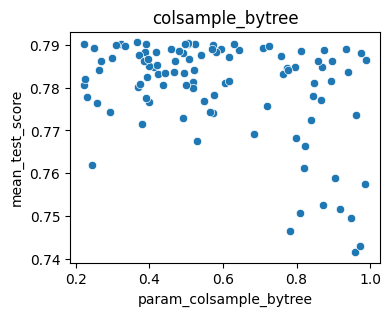

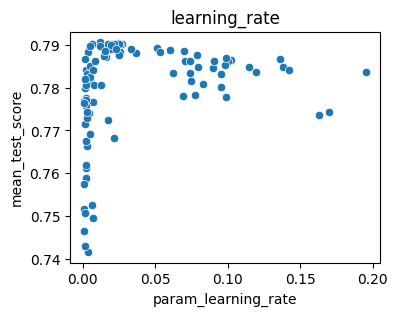

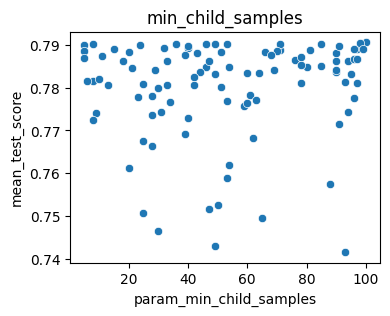

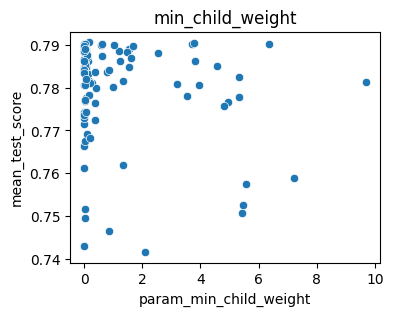

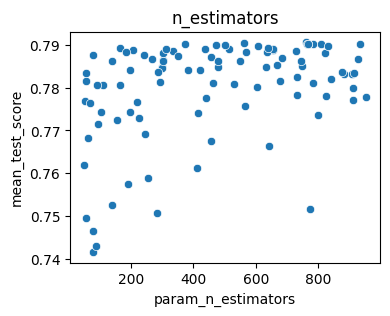

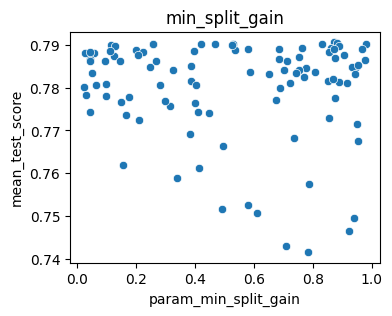

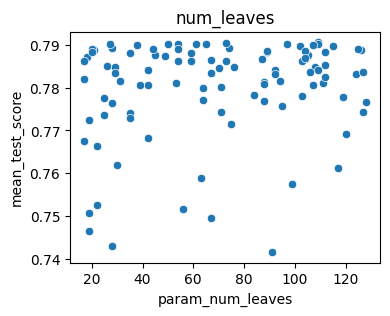

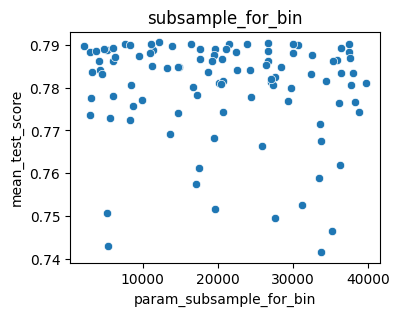

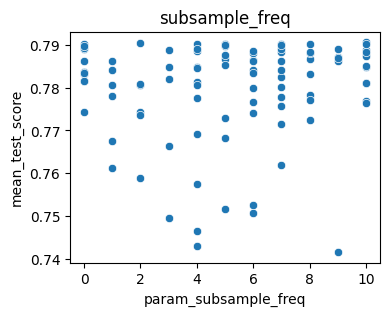

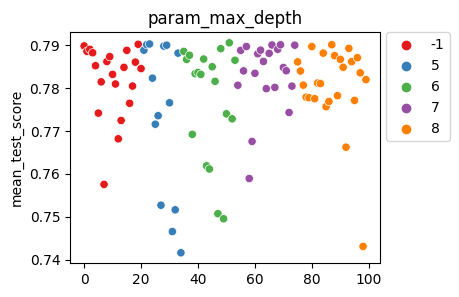

In [22]:
hp.plot_results()